In [25]:
import pandas as pd
import numpy as np
import cv2

In [20]:
img = cv2.imread('./data/SampleImage_grey.jpg', -1)

In [21]:
def image_display(img, title=None):
    if title is None:
        title = "image"
    cv2.imshow(title, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [22]:
image_display(img)

In [182]:
direction = np.array([1,0])

In [258]:
blur_img = pd.read_csv('./sample_blurred_image.csv', header=-1)
blur_img = np.array(blur_img)[:, 0:len(blur_img.columns)/3]
# decorr_img = decorr_image(blur_img, np.array([1,-1]))
# image_display(blur_img)
# image_display(decorr_img)

c:\python34\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


## [C] Decorrelating Real Image

In [107]:
def get_interpolate_value(img, direction):
    max_dir = max(abs(direction[0]), abs(direction[1]))
    direction = direction/max_dir
    itp_val = 0
    dirx = direction[0]
    diry = direction[1]
    
    pntx = 1
    pnty = 1
    if(dirx == 1):
        if(diry > 0): itp_val = (1-diry)*img[pnty, pntx+1] + diry*img[pnty+1, pntx+1]
        else: itp_val = (1+diry)*img[pnty, pntx+1] + -1*diry*img[pnty-1, pntx+1]
    elif(dirx == -1):
        if(diry > 0): itp_val = (1-diry)*img[pnty, pntx-1] + diry*img[pnty+1, pntx-1]
        else: itp_val = (1+diry)*img[pnty, pntx-1] + -1*diry*img[pnty-1, pntx-1]
    elif(diry == 1):
        if(dirx > 0): itp_val = (1-dirx)*img[pnty+1, pntx] + dirx*img[pnty+1, pntx+1]
        else: itp_val = (1+dirx)*img[pnty+1, pntx] + -1*dirx*img[pnty+1, pntx-1]
    elif(diry == -1):
        if(dirx > 0): itp_val = (1-dirx)*img[pnty-1, pntx] + dirx*img[pnty-1, pntx+1]
        else: itp_val = (1+dirx)*img[pnty-1, pntx] + -1*dirx*img[pnty-1, pntx-1]
    else:
        assert True, "exception"
    return itp_val

In [114]:
def decorr_image(img, direction):
    decorr_img = np.copy(img)
#     direction = -1 * np.copy(direction)
    for x in range(1, img.shape[0]-1):
        for y in range(1, img.shape[1]-1):
            sub_img = np.zeros((3,3))
            for _x in [-1,0,1]:
                for _y in [-1,0,1]:
                    sub_img[1+_x, 1+_y] = img[x+_x, y+_y]
            decorr_img[x,y] = img[x,y] - get_interpolate_value(sub_img, direction)                
    return decorr_img

In [261]:
def decorr_image_x(img):
    img_shiftx = np.array(pd.DataFrame(img).shift(1, axis=1).fillna(0))
    decorr_img_x = img - img_shiftx
    return decorr_img_x

def decorr_image_y(img):
    img_shifty = np.array(pd.DataFrame(img).shift(1).fillna(0))
    decorr_img_y = img - img_shifty
    return decorr_img_y

In [ ]:
decorr_img = decorr_image(img, direction)

In [173]:
# blur_img = pd.read_csv('./sample_blurred_image.csv', header=-1)
# blur_img = np.array(blur_img)[:, 0:len(blur_img.columns)/3]
# decorr_img = decorr_image(blur_img, np.array([1,-1]))
# image_display(blur_img)
# image_display(decorr_img)

In [111]:
# img_shifty = np.array(pd.DataFrame(img).shift(1).fillna(0))
# img_shiftx = np.array(pd.DataFrame(img).shift(1, axis=1).fillna(0))
# decorr_img_x = img - img_shiftx
# decorr_img_y = img - img_shifty
# image_display(decorr_img)
# image_display(decorr_img_x)

## [D] Extracting Motion Blur Correlation Properties

In [585]:
from scipy.ndimage import convolve
from scipy.signal import convolve2d
from scipy.ndimage import interpolation

In [656]:
def direction_filter(theta, unit='radian'):
    if unit != 'radian':
        theta = theta * np.pi/180
    flter1 = np.zeros((3,3))
    flter2 = np.zeros((3,3))
    if (theta >= 0 and theta <= np.pi/4):
        flter1 = np.array([[0, 0, 0], [1-np.tan(theta), -1, 0], [np.tan(theta), 0, 0]])/np.sqrt(1 + np.tan(theta)**2)
        flter2 = np.array([[0, 0, np.tan(theta)], [0, -1, 1-np.tan(theta)], [0, 0, 0]])/np.sqrt(1 + np.tan(theta)**2)
    elif (theta > np.pi/4 and theta <= np.pi/2):
        flter1 = np.array([[0, 0, 0], [0, -1, 0], [np.tan(np.pi/2-theta), 1-np.tan(np.pi/2-theta), 0]])/np.sqrt(1 + np.tan(np.pi/2-theta)**2)
        flter2 = np.array([[0, 1-np.tan(np.pi/2-theta), np.tan(np.pi/2-theta)], [0, -1, 0], [0, 0, 0]])/np.sqrt(1 + np.tan(np.pi/2-theta)**2)
    elif (theta > np.pi/2 and theta <= np.pi/4*3):
        flter1 = np.array([[0, 0, 0], [0, -1, 0], [0, 1-np.tan(theta-np.pi/2), np.tan(theta-np.pi/2)]])/np.sqrt(1 + np.tan(theta-np.pi/2)**2)
        flter2 = np.array([[np.tan(theta-np.pi/2), 1-np.tan(theta-np.pi/2), 0], [0, -1, 0], [0, 0, 0]])/np.sqrt(1 + np.tan(theta-np.pi/2)**2)
    elif (theta > np.pi/4*3 and theta <= np.pi):
        flter1 = np.array([[0, 0, 0], [0, -1, 1-np.tan(np.pi-theta)], [0, 0, np.tan(np.pi-theta)]])/np.sqrt(1+np.tan(np.pi-theta)**2)
        flter2 = np.array([[np.tan(np.pi-theta), 0, 0], [1-np.tan(np.pi-theta), -1, 0], [0, 0, 0]])/np.sqrt(1+np.tan(np.pi-theta)**2)
    else: assert 1==1, "Wrong Theta"
    return flter1, flter2

In [657]:
def detect_blur_direction(blur_img, true_theta, scale = 10, plot=False):
    intensities1 = pd.Series(index=range(0,180*scale,1))
    intensities2 = pd.Series(index=range(0,180*scale,1))
    intensities1.index = intensities1.index / scale
    intensities2.index = intensities2.index / scale
    min_theta = 0
    min_intensity = -1
    for k in intensities1.index:
#         conv_img = convolve(blur_img, direction_filter(np.pi/180*k), mode='wrap')
        filters = direction_filter(np.pi/180*k)
        conv_img1 = convolve2d(blur_img, filters[0], mode='same', boundary='symm')
        conv_img2 = convolve2d(blur_img, filters[1], mode='same', boundary='symm')
        intensity1 = sum(sum(abs(conv_img1[1:-1,1:-1])))
        intensity2 = sum(sum(abs(conv_img2[1:-1,1:-1])))
        intensities1.loc[k] = intensity1
        intensities2.loc[k] = intensity2
        if(min_intensity == -1 or min_intensity > intensity1):
            min_theta = k
            min_intensity = intensity1
        if(min_intensity == -1 or min_intensity > intensity2):
            min_theta = k
            min_intensity = intensity2
            
#     print("theta: ",true_theta,"min_dir: ",min_dir," min_theta: ", min_theta)
    if plot:
        intensities1.plot(title='blur_direction-theta: '+str(i)+' Detected Theta: '+str(min_theta))
        intensities2.plot(title='blur_direction-theta: '+str(i)+' Detected Theta: '+str(min_theta))
        plt.show()
    return min_theta

In [662]:
def autocorr(blur_img, rot_direction):
    if rot_direction == 'x':
        blur_derivative_img = pd.DataFrame(blur_img).shift(1, axis=1) - pd.DataFrame(blur_img)
        blur_derivative_img = blur_derivative_img.fillna(0)
        autocorrelations = pd.Series(index=blur_derivative_img.columns)
    else:
#         rot_direction == 'y'
        blur_derivative_img = pd.DataFrame(blur_img).shift(1, axis=0) - pd.DataFrame(blur_img)
        blur_derivative_img = blur_derivative_img.fillna(0)
        autocorrelations = pd.Series(index=blur_derivative_img.index)
        
    for shift in autocorrelations.index:
        if(rot_direction == 'x'):
            autocorrelations.loc[shift] = (blur_derivative_img * blur_derivative_img.shift(shift, axis=1)).sum(axis=1).mean()
        else:
            autocorrelations.loc[shift] = (blur_derivative_img * blur_derivative_img.shift(shift, axis=0)).sum(axis=0).mean()
    return autocorrelations

In [663]:
def get_blur_parameter(blur_img, detect_sensitivity=1, true_val=None):
    min_theta = detect_blur_direction(blur_img, 0, scale=detect_sensitivity, plot=True)
    rot_direction = 'x'
    if true_val is not None:
        min_theta = true_val
    if (min_theta >= 0 and min_theta < 45) or (min_theta >= 135 and min_theta <= 180):
        rot_blur_img = interpolation.rotate(blur_img, -min_theta)
        rot_direction = 'x'
    else:
        rot_blur_img = interpolation.rotate(blur_img, (90-min_theta))
        rot_direction = 'y'
    
    autocorrelations = autocorr(rot_blur_img, rot_direction)
    autocorrelations = autocorrelations.iloc[0:int(len(autocorrelations.index)/4*3)]
    magnitude = autocorrelations.loc[lambda x: x==autocorrelations.min()].index[0]
    return min_theta, magnitude, autocorrelations

In [664]:
# blur_img = pd.read_csv('./data/sample_blurred_image30.csv', header=-1)
# blur_img = np.array(blur_img)[:, 0:len(blur_img.columns)/3]
# ret = get_blur_parameter(blur_img)

c:\python34\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


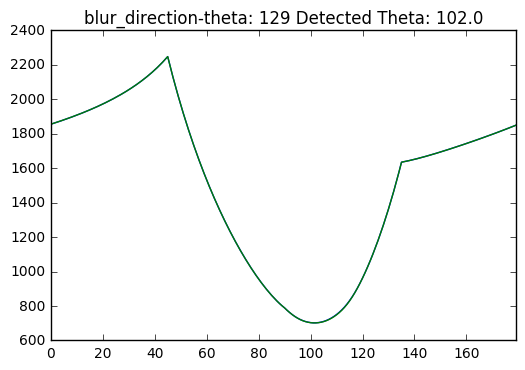

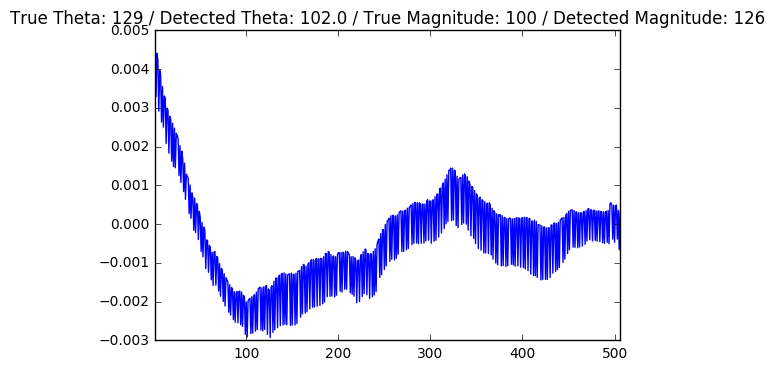

In [651]:
blur_img = pd.read_csv('./data/sample_blurred_image114.csv', header=-1)
blur_img = np.array(blur_img)[:, 0:len(blur_img.columns)/3]
theta, magnitude, ac = get_blur_parameter(blur_img, true_val=-66)
ac.iloc[1:].plot(title='True Theta: '+str(i)+' / Detected Theta: '+str(theta)+' / True Magnitude: '+str(100)+' / Detected Magnitude: '+str(magnitude))
plt.show()

c:\python34\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


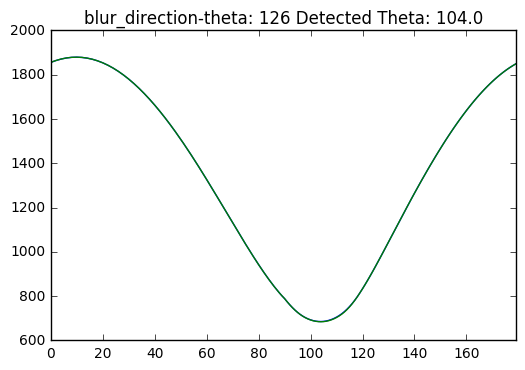

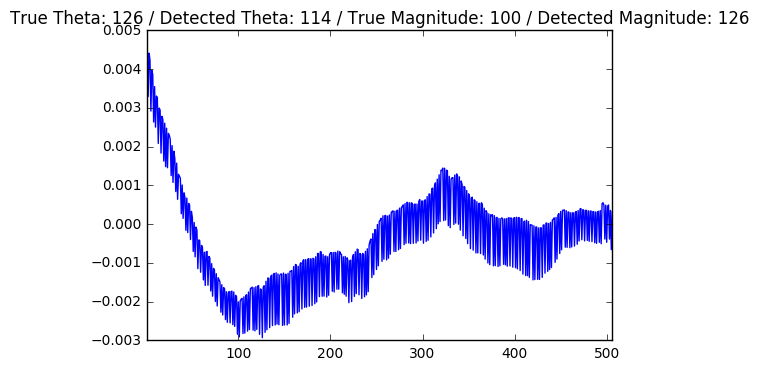

In [667]:
blur_img = pd.read_csv('./data/sample_blurred_image114.csv', header=-1)
blur_img = np.array(blur_img)[:, 0:len(blur_img.columns)/3]
theta, magnitude, ac = get_blur_parameter(blur_img, true_val=114)
ac.iloc[1:].plot(title='True Theta: '+str(i)+' / Detected Theta: '+str(theta)+' / True Magnitude: '+str(100)+' / Detected Magnitude: '+str(magnitude))
plt.show()

c:\python34\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


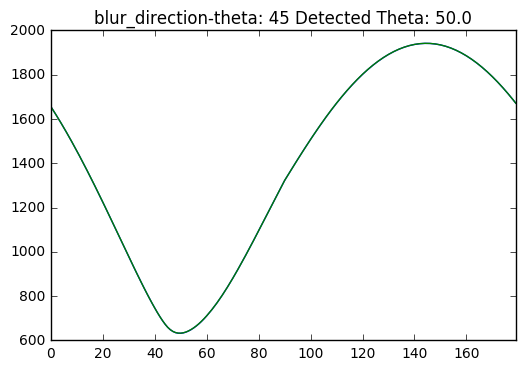

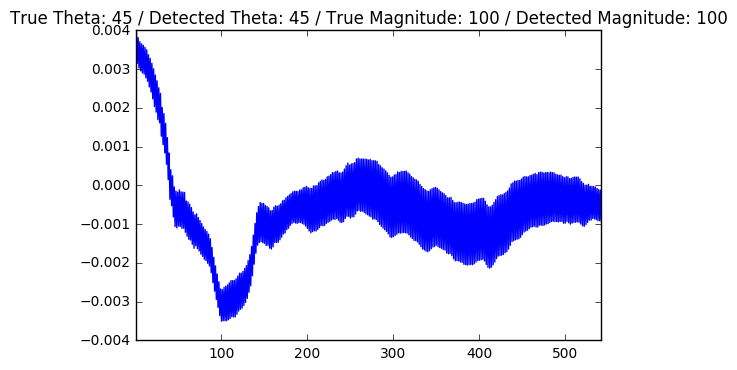

c:\python34\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


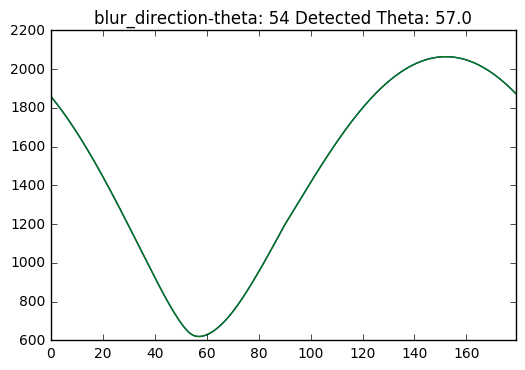

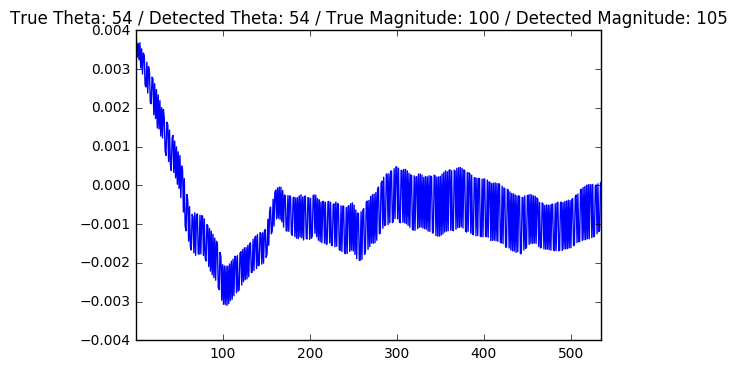

c:\python34\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


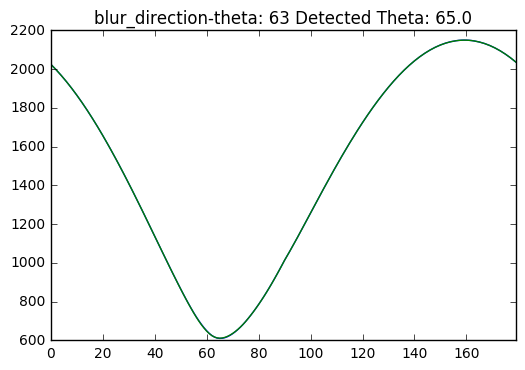

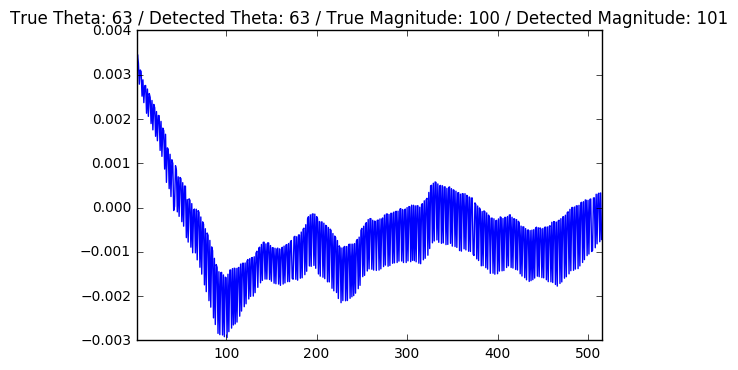

c:\python34\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


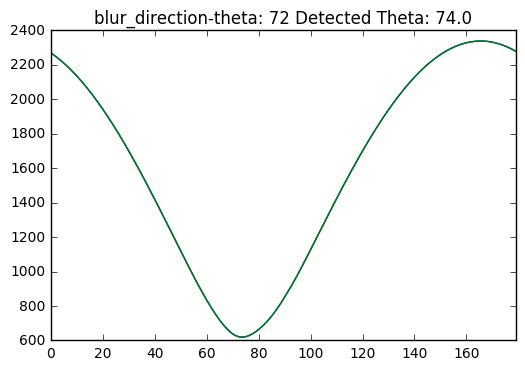

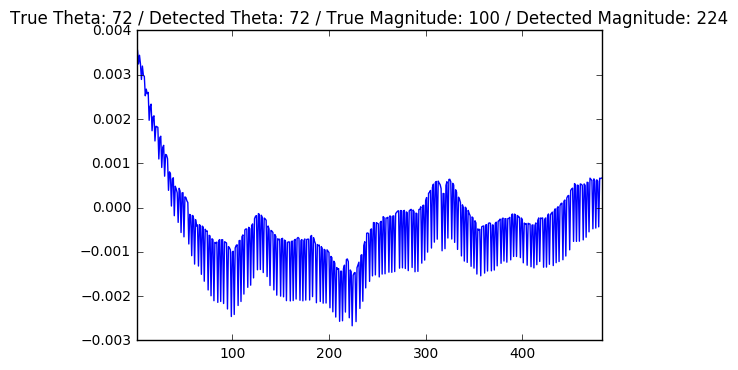

c:\python34\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


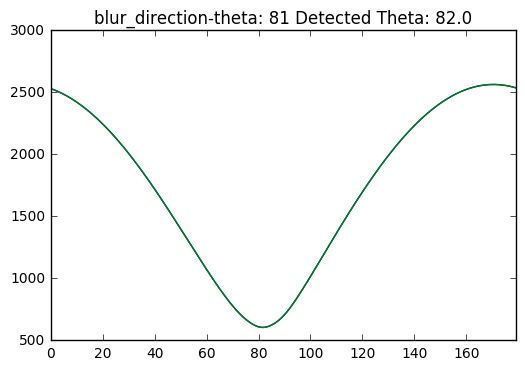

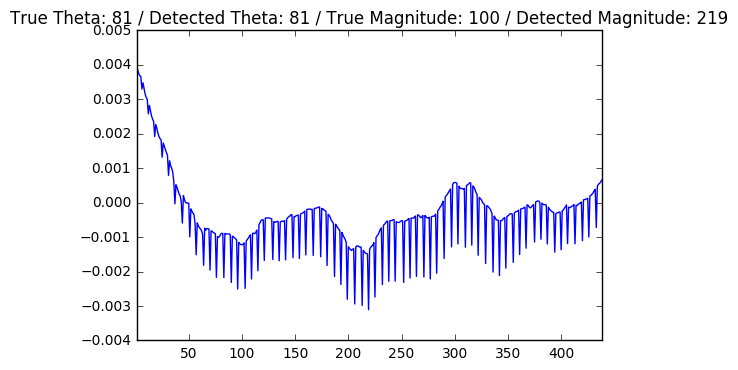

c:\python34\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


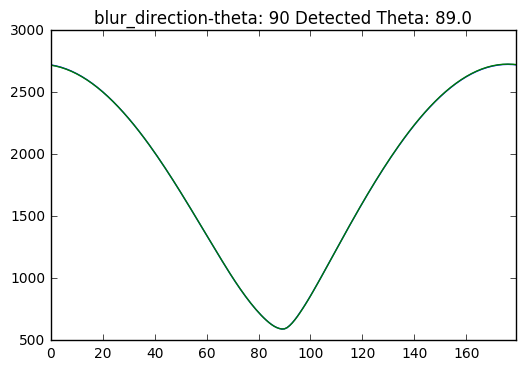

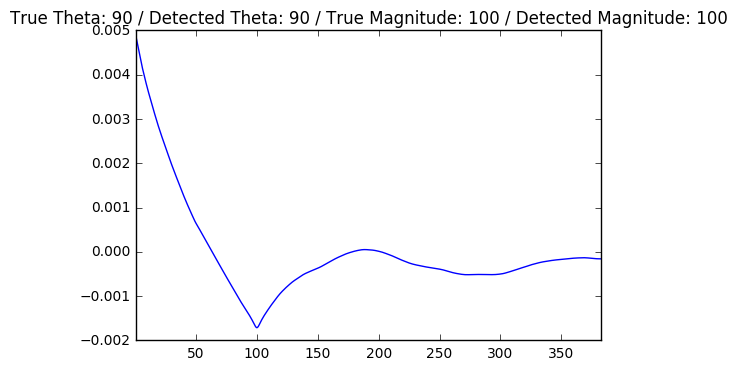

c:\python34\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


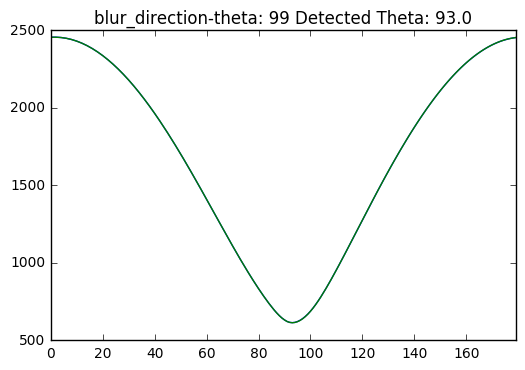

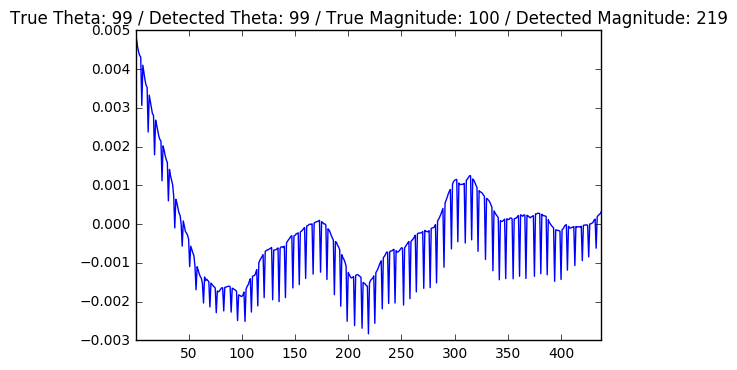

c:\python34\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


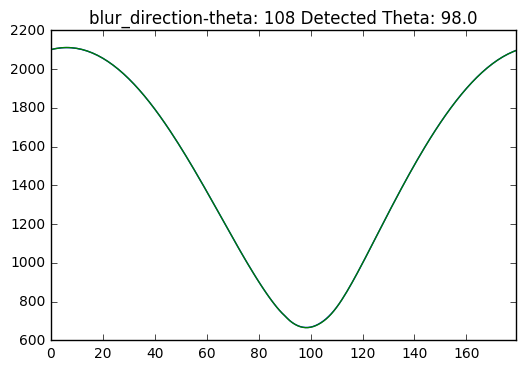

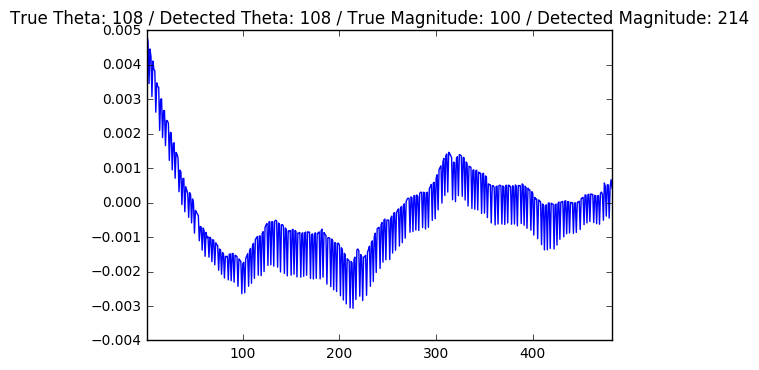

c:\python34\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


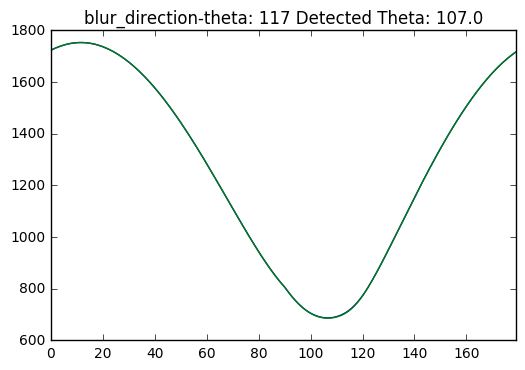

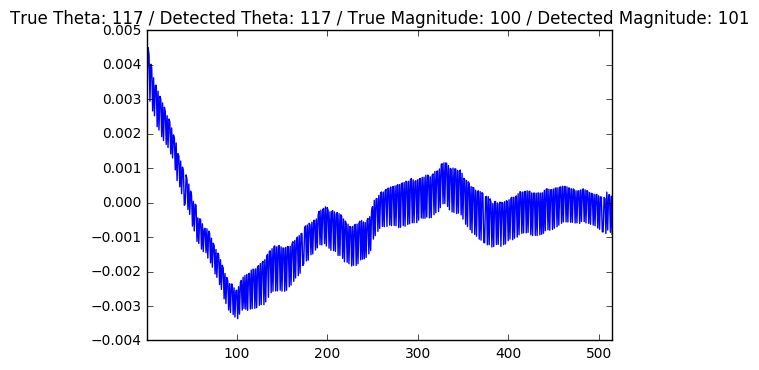

c:\python34\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


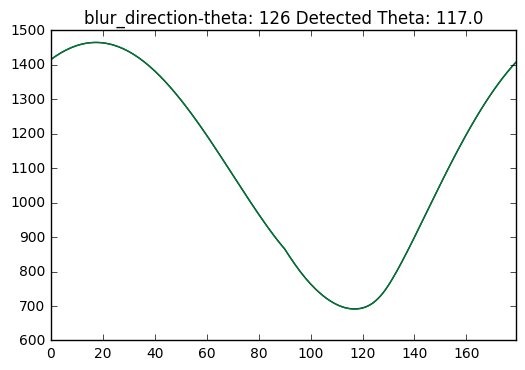

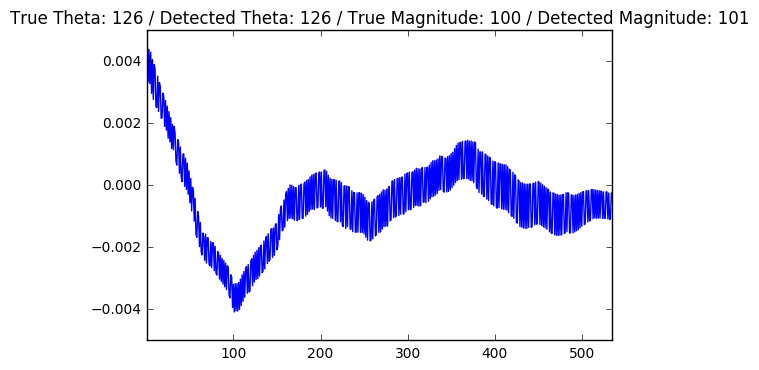

In [665]:
for i in range(45,135,9):
    blur_img = pd.read_csv('./data/sample_blurred_image'+str(i)+'.csv', header=-1)
    blur_img = np.array(blur_img)[:, 0:len(blur_img.columns)/3]
    theta, magnitude, ac = get_blur_parameter(blur_img, true_val=i)
    ac.iloc[1:].plot(title='True Theta: '+str(i)+' / Detected Theta: '+str(theta)+' / True Magnitude: '+str(100)+' / Detected Magnitude: '+str(magnitude))
    plt.show()